## **I wanted to experiment with navigation algorithms, generating an efficient path between two points within a network. Below is my first attempt.**

In [2]:
import random, copy
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from IPython.display import clear_output 
import time

______________________________________________________________________________

First we need a function that generates a network to navigate. I'll keep it relatively simple with a list of lists that will represent a grid of squares that can be navigated in each direction to neighbouring squares. Some square ares not navigable and will serve as barriers. Navigable squares will be represented with a 0, barriers will be a 1.

In [1]:
def generate_grid(height, width, barrier_rate):

    limiting = width

    if width > height:
        limiting = height

    if barrier_rate > 40:
        barrier_rate = 40

    grid = [[0 for x in range(width)] for y in range(height)]

    for y in range(len(grid)):
        for x in range(len(grid[0])):
            barrier = random.randint(1,100//barrier_rate)
            if barrier == 1:
                barrier_len = random.randint(1,round(limiting**0.5))
                barrier_orient = random.randint(0,1)
                if barrier_orient == 0:
                    if barrier_len > len(grid[0]) - x:
                        barrier_len = len(grid[0]) - x
                    grid[y][x:x+barrier_len] = [1 for i in range(barrier_len)]
                else:
                    if barrier_len > len(grid) - y:
                        barrier_len = len(grid) - y
                    for j in range(barrier_len):
                        grid[y+j][x] = 1
    return grid

In [10]:
test_grid = generate_grid(20,20,10)
test_grid

[[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

______________________________________________________________________________

For clarity, the below function displays the network using matplotlib.imshow

In [46]:
def show_grid(grid, figsize = (15,15)):

    # For specific case when so route can be found (relevant later in notebook)
    if not grid[0]:
        return 'No possible route'

    # Displays coloured grid with coordinates as axis labels
    cmap = cmap = colors.ListedColormap(['LightGrey', 'coral', 'LawnGreen', 'g', 'r'])
    fig, ax = plt.subplots(figsize = figsize)
    bounds = [0,0.5,1.5,2.5,3.5,4]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(ticks = np.arange(-.5, len(grid[0]), 1));
    ax.set_yticks(np.arange(-.5, len(grid), 1));
    ax.tick_params(labelbottom=True,labelleft=True, labeltop = True, labelright = True)
    ax.set_xticklabels(range(0,len(grid[0])))
    ax.set_yticklabels(range(0,len(grid)))
    ax.imshow(grid, cmap=cmap, norm=norm)
    plt.show()

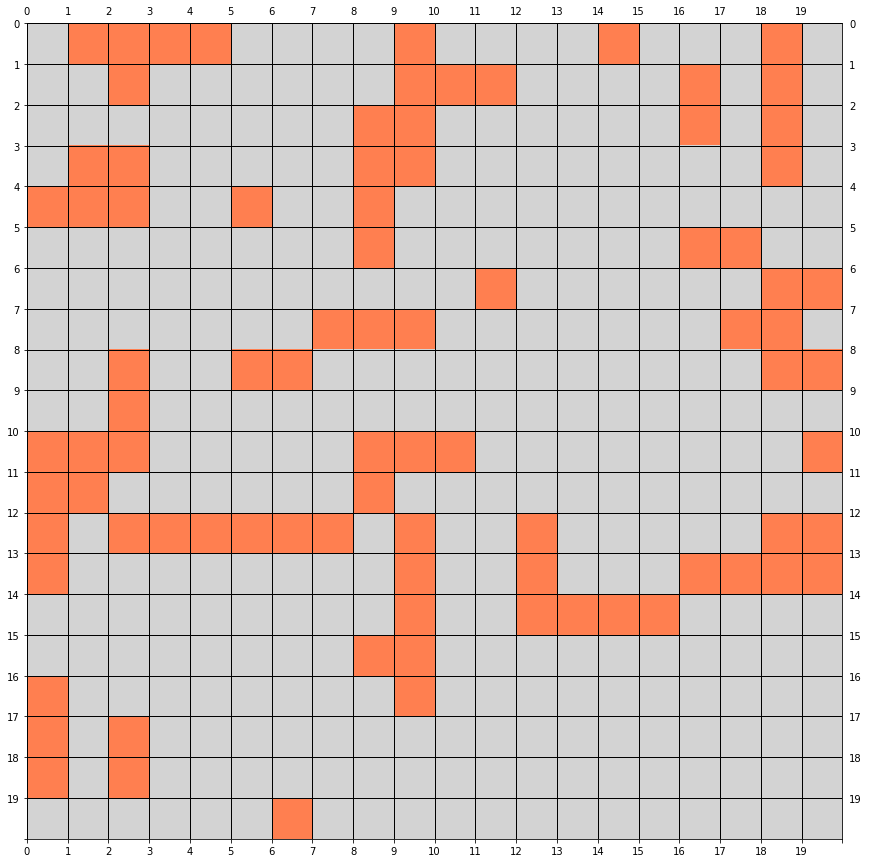

In [13]:
show_grid(test_grid,(15,15))

______________________________________________________________________________

The system will use cartesian style coordinates to index each square. The below function finds the coordinates of all neighbouring squares, given a single input square.

In [14]:
def get_neighbours(y,x,grid):
    #lists neighbour squares for a given square

    neighbours = []

    for i in [-1,1]:
        
        if -1 < y + i < len(grid):
            neighbours.append((y + i, x))
        if -1 < x + i < len(grid[0]):
            neighbours.append((y, x + i))
        
    return neighbours

In [15]:
# Testing corner
get_neighbours(0,0,test_grid)

[(1, 0), (0, 1)]

In [16]:
# Testing middle
get_neighbours(5,10,test_grid)

[(4, 10), (5, 9), (6, 10), (5, 11)]

In [17]:
# Testing middle
get_neighbours(19,9,test_grid)

[(18, 9), (19, 8), (19, 10)]

______________________________________________________________________________

The below function returns a tuple, composing a list of all navigable squares (non barriers) and a dictionary, where the keys are each navigable coordinate, values a list of each navigable neighbour to that square.

In [4]:
def navigable_neighbours(grid):

    navigable = []
    neighbours = {}
    for y in range(len(grid)):
        for x in range(len(grid[0])):
            if grid[y][x] == 0:
                navigable.append((y,x))
                neighbours[(y,x)] = [loc for loc in get_neighbours(y,x,grid) if grid[loc[0]][loc[1]] == 0]

    return navigable, neighbours

In [18]:
navigable_neighbours(test_grid)[0]

[(0, 0),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 19),
 (1, 0),
 (1, 1),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 17),
 (1, 19),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 17),
 (2, 19),
 (3, 0),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 19),
 (4, 3),
 (4, 4),
 (4, 6),
 (4, 7),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (4, 19),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 18),
 (5, 19),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 

In [19]:
navigable_neighbours(test_grid)[1]

{(0, 0): [(1, 0)],
 (0, 5): [(1, 5), (0, 6)],
 (0, 6): [(0, 5), (1, 6), (0, 7)],
 (0, 7): [(0, 6), (1, 7), (0, 8)],
 (0, 8): [(0, 7), (1, 8)],
 (0, 10): [(0, 11)],
 (0, 11): [(0, 10), (0, 12)],
 (0, 12): [(0, 11), (1, 12), (0, 13)],
 (0, 13): [(0, 12), (1, 13)],
 (0, 15): [(1, 15), (0, 16)],
 (0, 16): [(0, 15), (0, 17)],
 (0, 17): [(0, 16), (1, 17)],
 (0, 19): [(1, 19)],
 (1, 0): [(0, 0), (2, 0), (1, 1)],
 (1, 1): [(1, 0), (2, 1)],
 (1, 3): [(2, 3), (1, 4)],
 (1, 4): [(1, 3), (2, 4), (1, 5)],
 (1, 5): [(0, 5), (1, 4), (2, 5), (1, 6)],
 (1, 6): [(0, 6), (1, 5), (2, 6), (1, 7)],
 (1, 7): [(0, 7), (1, 6), (2, 7), (1, 8)],
 (1, 8): [(0, 8), (1, 7)],
 (1, 12): [(0, 12), (2, 12), (1, 13)],
 (1, 13): [(0, 13), (1, 12), (2, 13), (1, 14)],
 (1, 14): [(1, 13), (2, 14), (1, 15)],
 (1, 15): [(0, 15), (1, 14), (2, 15)],
 (1, 17): [(0, 17), (2, 17)],
 (1, 19): [(0, 19), (2, 19)],
 (2, 0): [(1, 0), (3, 0), (2, 1)],
 (2, 1): [(1, 1), (2, 0), (2, 2)],
 (2, 2): [(2, 1), (2, 3)],
 (2, 3): [(1, 3), (2, 2)

______________________________________________________________________________

Below is the logic that finds the most direct route between two points, in the form of a function.

In [43]:
def navigate(start, end, grid):
    # Input, start coordinate, end coordinate and grid
    
    # Create dictionary of navigable neighbours for each point
    neighbours = navigable_neighbours(grid)[1]

    # Initiate a list of routes, each route will be in list form representing a
    #sequential path to other sqaures. The list is initiated with a trivial 
    #route describing how to navigate to the start point which obviously,
    #contains only the start point.
    active_routes = [[start]]
    
    # Removes the start point from all value lists in the neighbours dictionary.
    #we already know how to reach this point and are not intersetd in any other
    #routes to this coordinate as they must be longer than the route we have. 
    for i in neighbours.values():
        if start in i:
            i.remove(start)

    # Initiate another list where all routes that make their way to a dead end 
    #(square with no remaining navigable neighbours) will be appended to. 
    primary_routes = []

    progressing = True
    while progressing:

        # Set progressing to False by default.
        progressing = False

        # Sets a clean list for route building with each loop
        route_progression = []

        #find navigable options for the current end coordinate of each route.
        for route in active_routes:
            options = neighbours[route[-1]].copy()
            #if a given route has nowhere to proceed. Append it to the primary 
            #routes list.
            if options == []:
                primary_routes.append(route)
            else:
                #if any route has options, set progressing to true to continue 
                #the overarching while loop.
                progressing = True

            # For each route (list of sequential coordinates (route seed below))
            #, find the options (remaining navigable neighbours) for the final 
            #coordinate. Duplicate the list for each navigable neighgbour (opt) 
            #and append a different neighbour to each, creating a new route that 
            #leads from the start point to each of those neighbours (options).
            for opt in options:
                
                route_seed = route.copy()
                route_seed.append(opt)
                route_progression.append(route_seed)
                
                #Once a square has been reached by any route, remove it from all
                #navigable neighbours dictionay values. This ensures no less 
                #direct routes will be made to that coordinate. 
                for i in neighbours.values():
                    if opt in i:
                        i.remove(opt) 
        # The active routes have now been progressed in all feasable directions
        #in the route progression list which should now superscede the active 
        #routes list
        active_routes = route_progression
    
    primary_routes.extend(route_progression)

    for i in primary_routes:
        if end in i:
            for j in range(len(i)):
                if i[j] == end:
                    return i[:j+1]
    
    return False, 'No possible route'

In [50]:
# Testing navigate which should return a list of sequential coordinates between
# start and end
start = 0,0
end = 17,19
navigate(start, end, test_grid)

[(0, 0),
 (1, 0),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 3),
 (4, 3),
 (5, 3),
 (6, 3),
 (7, 3),
 (8, 3),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9),
 (9, 10),
 (9, 11),
 (10, 11),
 (11, 11),
 (12, 11),
 (13, 11),
 (14, 11),
 (15, 11),
 (16, 11),
 (17, 11),
 (17, 12),
 (17, 13),
 (17, 14),
 (17, 15),
 (17, 16),
 (17, 17),
 (17, 18),
 (17, 19)]

______________________________________________________________________________

We now need a function that maps the start, end and path onto the network, represented by 3, 2 and 4 respectively. 

In [44]:
def grid_path(start, end, grid):
    
    path = navigate(start, end, grid)

    if not path[0]:
        return False, 'No possible route' 

    grid_path = copy.deepcopy(grid)

    grid_path[start[0]][start[1]] = 3
    grid_path[end[0]][end[1]] = 4

    for coord in path[1:-1]:
        y = coord[0]
        x = coord[1]
        grid_path[y][x] = 2

    return grid_path

In [51]:
# Testing grid_path mapping
grid_path(start, end, test_grid)

[[3, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
 [2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0,

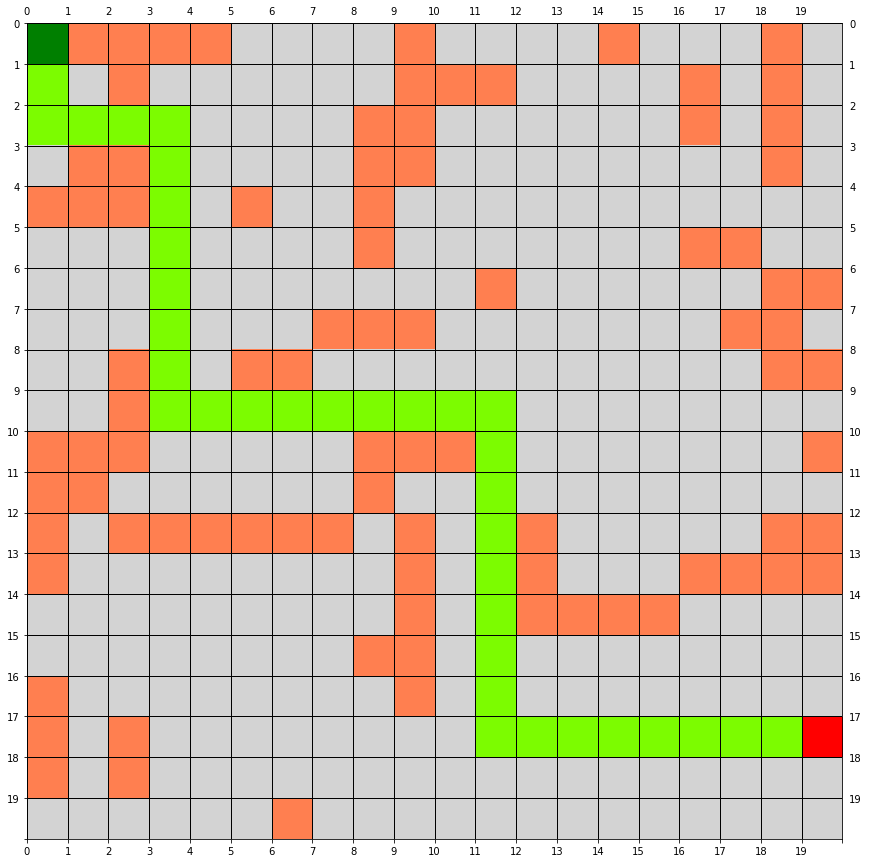

In [52]:
show_grid(grid_path(start, end, test_grid))

In [53]:
# Test for impossible route

start = 0,0
impossible_end = 7,19
show_grid(grid_path(start, impossible_end, test_grid))

'No possible route'

______________________________________________________________________________

Testing for more complex networks

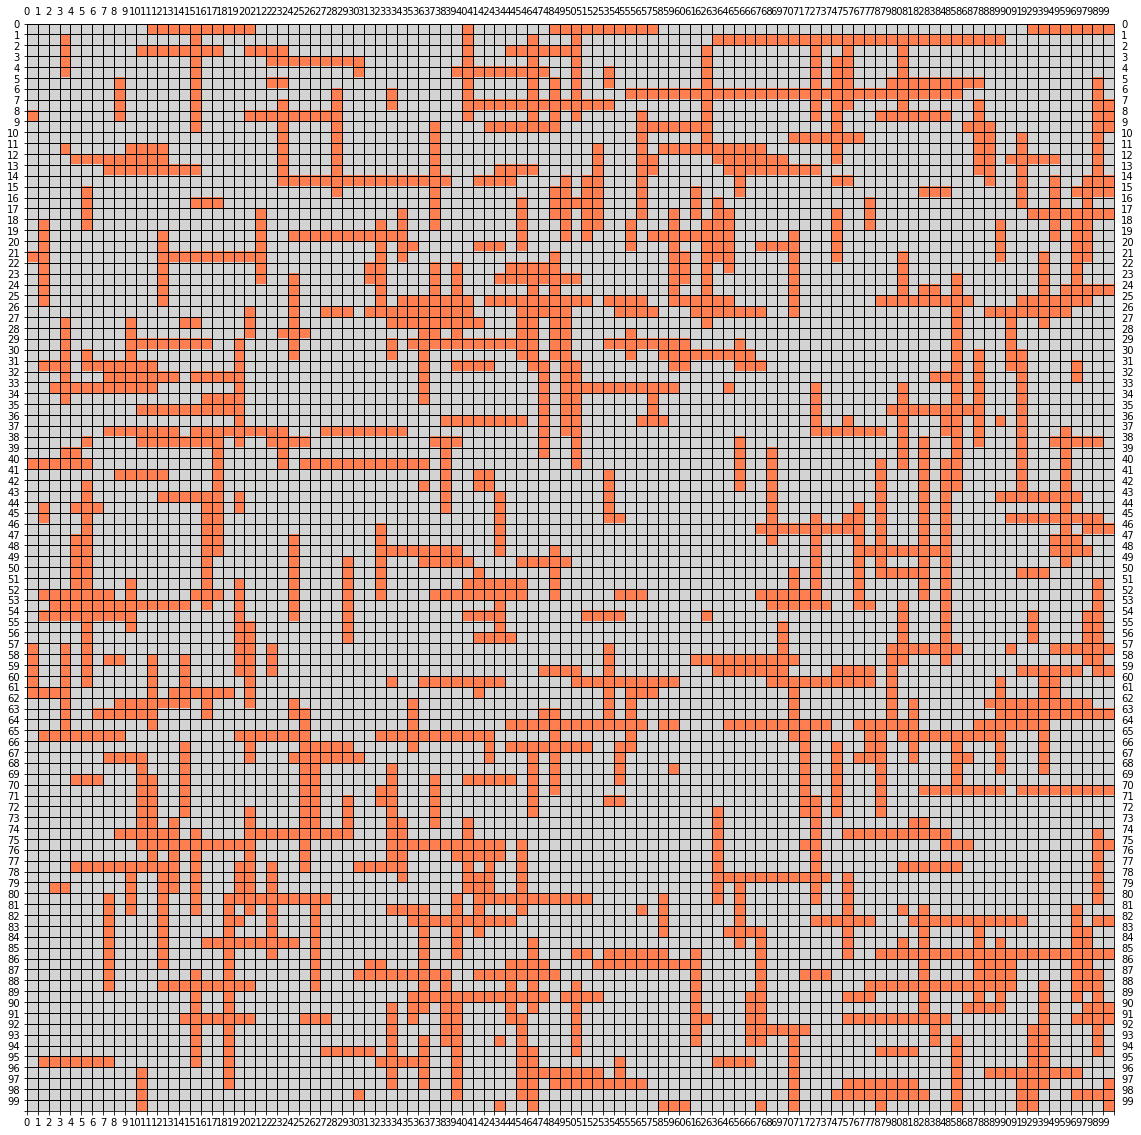

In [58]:
complex_grid = generate_grid(100,100,5)
show_grid(complex_grid,(20,20))

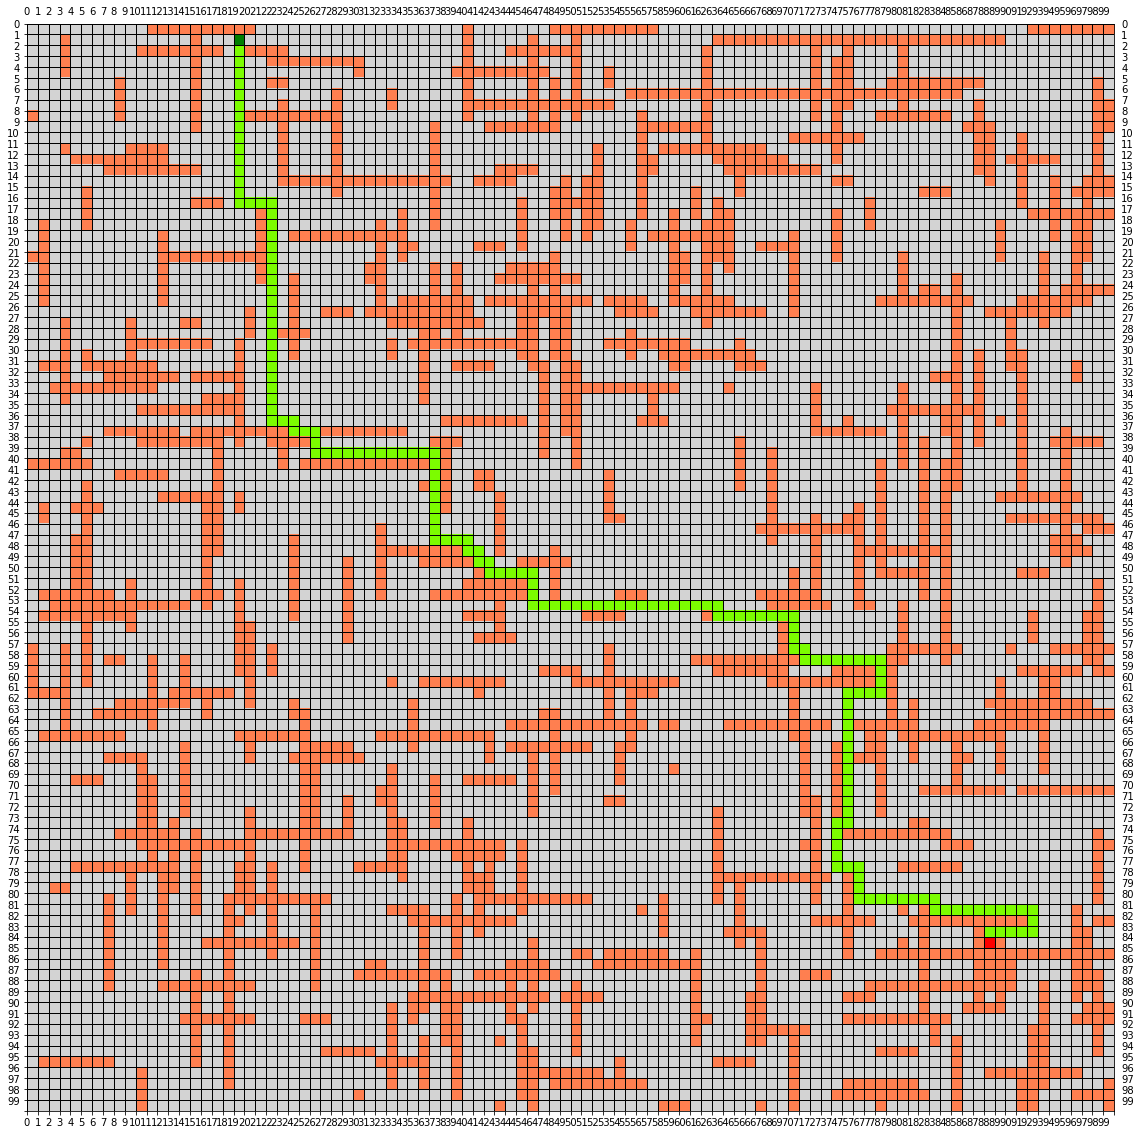

In [61]:
start_complex = 1,19
end_complex = 84,88
show_grid(grid_path(start_complex, end_complex, complex_grid), (20,20))